In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd



df = pd.read_csv('geo_routes.csv')
df.columns = df.columns.str.strip()

# G contains the airports as nodes and the routes as directed edges



G = nx.DiGraph()

# Add nodes and edges to the graph
unfound_airport_codes = set()

for index, row in df.iterrows():
    source_airport = row['source airport']
    destination_airport = row['destination apirport']  # for some reason `destination airport` is spelled wrong in the spreadsheet
    airline_code = row['airline']
    num_stops = row['stops']
    # equipment_used = row['equipment']

    airline = row['Airline Name']
    alliance = row['Flight Alliance']

    src_lat = row['lat_src']
    src_lng = row['lng_src']
    src_elev = row['elevation_src']

    dest_lat = row['lat_dest']
    dest_lng = row['lng_dest']
    dest_elev = row['elevation_dest']

    


    # I wanted to add equipment but it seems that b/c the equipment_used row is full of different types of data values
    # it can't be imported into Gephi

    
    # add nodes for the airports if they are not already in the graph
    
    
    
    if row['source airport'] not in G:
        G.add_node(source_airport, airline = airline_code, stops = num_stops, latitude=src_lat, longitude=src_lng, elevation=src_elev)
    if row['destination apirport'] not in G:
        G.add_node(destination_airport, airline = airline_code, stops = num_stops, latitude=dest_lat, longitude=dest_lng, elevation=dest_elev)
    
    # Add a directed edge from Source to Destination
    G.add_edge(source_airport, destination_airport, airline_name=airline, flight_alliance=alliance)






nx.write_graphml(G, "network.graphml")

In [3]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  3425
Number of edges:  37595

Average degree:  21.953284671532845
Average degree (alternate calculation) 21.953284671532845

Minimum degree:  1
Maximum degree:  477


In [4]:
# find number of strongly and weakly connected components
num_strongly_connected = nx.number_strongly_connected_components(G)
num_weakly_connected = nx.number_weakly_connected_components(G)

# find largest strongly and weakly connected components
largest_strongly_connected = max(nx.strongly_connected_components(G), key=len)
largest_weakly_connected = max(nx.weakly_connected_components(G), key=len)

print("Number of strongly connected components:", num_strongly_connected)
print("Number of weakly connected components:", num_weakly_connected)
print("Size of the largest strongly connected component:", len(largest_strongly_connected))
print("Size of the largest weakly connected component:", len(largest_weakly_connected))


Number of strongly connected components: 44
Number of weakly connected components: 8
Size of the largest strongly connected component: 3354
Size of the largest weakly connected component: 3397


In [5]:
density = nx.density(G)
print("Network density:", density)


Network density: 0.003205795074698138


In [6]:
# idk if i even doing this right, just some stastic that looked interesting.
avg_clustering = nx.average_clustering(G.to_undirected())
print("Average clustering coefficient:", avg_clustering)


Average clustering coefficient: 0.4870933566129556


In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [8]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

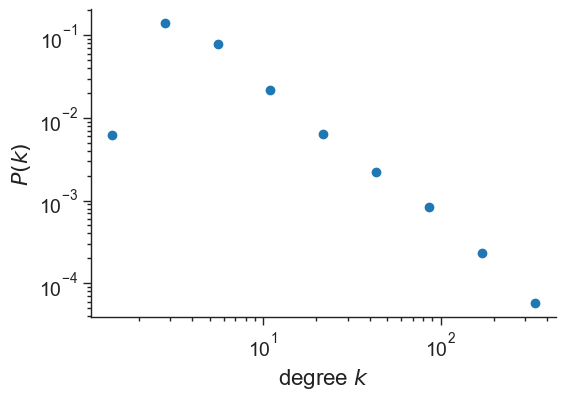

In [9]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [10]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

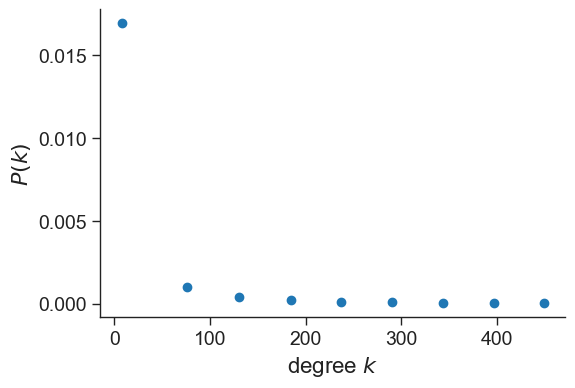

In [11]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

NameError: name 'centrality_df' is not defined

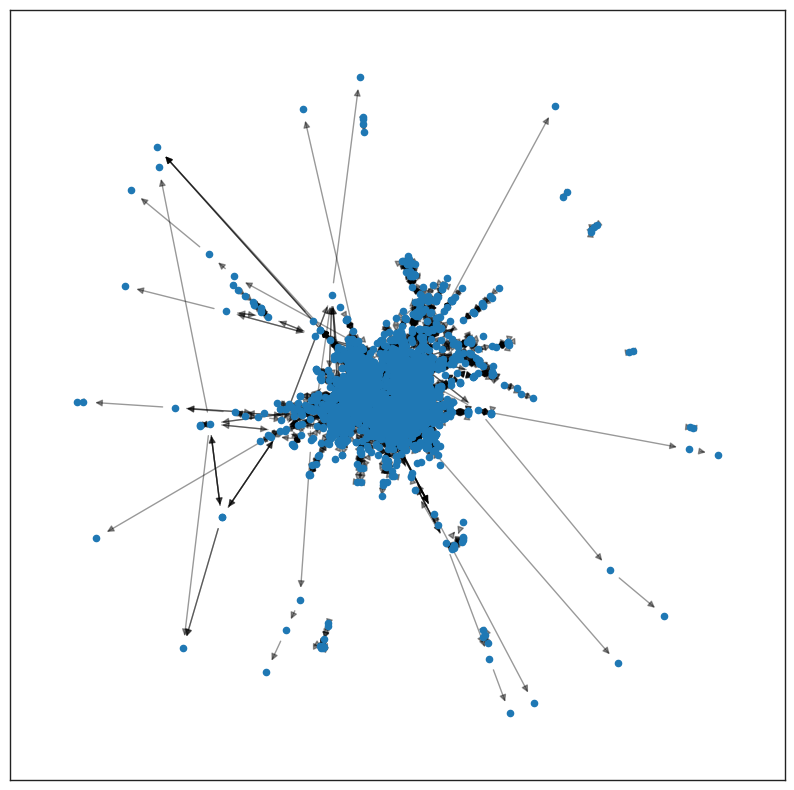

In [12]:
# Example for a simple network visualization highlighting hubs
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Highlight hubs
hub_nodes = centrality_df.head(10)['Airport']  # Top 10 hubs for illustration
nx.draw_networkx_nodes(G, pos, nodelist=hub_nodes, node_color='r', node_size=50)

plt.title('Flight Network with Highlighted Hubs')
plt.axis('off')
plt.show()

In [ ]:
print(centrality_df)

     Airport  Centrality
502      FRA    0.139311
449      CDG    0.137266
227      AMS    0.135222
797      IST    0.133470
202      ATL    0.126460
...      ...         ...
1896     FMI    0.000292
2175     TUA    0.000292
2695     BVS    0.000292
87       KPR    0.000292
2409     KZI    0.000292

[3425 rows x 2 columns]


In [ ]:
import pycountry
import pycountry_convert as pc
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm
import json
import os

cache_file_path = 'geocode_cache.json'

# Check if the cache file exists and load it, or initialize an empty cache
if os.path.exists(cache_file_path):
    with open(cache_file_path, 'r') as cache_file:
        geocode_cache = json.load(cache_file)
else:
    geocode_cache = {}




geolocator = Nominatim(user_agent="flight-route-analysis@eric.mao")

# Define a rate-limiter to avoid overloading the geocoding service
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=2)
def get_country_continent(coords):
    # Check cache first
    if coords in geocode_cache:
        return geocode_cache[coords].get('country', ''), geocode_cache[coords].get('continent', '')
    
    # If not in cache, perform geocoding
    location = geocode(coords, language='en')
    if location:
        address = location.raw['address']
        country_name = address.get('country', '')
        continent_name = ''
        try:
            country_code = pycountry.countries.lookup(country_name).alpha_2
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        except (LookupError, KeyError):
            print(f"Could not determine continent for {country_name}")
            # If the continent can't be determined, proceed with only country name
        
        # Update cache with whatever information is available (country and/or continent)
        geocode_cache[coords] = {'country': country_name, 'continent': continent_name}
        
        # Save the updated cache to the file
        with open(cache_file_path, 'w') as cache_file:
            json.dump(geocode_cache, cache_file, indent=4)
        
        return country_name, continent_name
    else:
        # If geocoding fails, return empty strings
        return '', ''



# create a dictionary mapping airport -> country.
for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"
    country, continent = get_country_continent(coords)

   



NameError: name 'final_df' is not defined

In [ ]:
# Calculate in-degree and out-degree for each node (airport) in the graph
in_degree_dict = dict(G.in_degree())  # Returns a dictionary with nodes and their in-degree
out_degree_dict = dict(G.out_degree())  # Returns a dictionary with nodes and their out-degree


# Calculate total degree by adding in-degree and out-degree
total_degree_dict = {node: in_degree + out_degree_dict[node] for node, in_degree in in_degree_dict.items()}

# Calculate the highest degree centrality and merge it with latitude, longitude, elevation data.
airports_info = pd.concat([
    df[['source airport', 'lat_src', 'lng_src', 'elevation_src']].rename(columns={
        'source airport': 'Airport',
        'lat_src': 'Latitude',
        'lng_src': 'Longitude',
        'elevation_src': 'Elevation'
    }),
    df[['destination apirport', 'lat_dest', 'lng_dest', 'elevation_dest']].rename(columns={
        'destination apirport': 'Airport',
        'lat_dest': 'Latitude',
        'lng_dest': 'Longitude',
        'elevation_dest': 'Elevation'
    })
]).drop_duplicates('Airport').reset_index(drop=True)


degree_centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Airport', 'Centrality']).sort_values(by='Centrality', ascending=False)
final_df = centrality_df.merge(airports_info, on='Airport', how='left')


final_df['Country'] = None
final_df['Continent'] = None

for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"

    # Check if the coords are in the cache
    if coords in geocode_cache:
        # Correctly access the country and continent from the cache
        final_df.at[index, 'Country'] = geocode_cache[coords]['country']
        final_df.at[index, 'Continent'] = geocode_cache[coords]['continent']
    else:
        # Handle cases where coordinates are not in the cache, if necessary
        final_df.at[index, 'Country'] = 'Unknown'
        final_df.at[index, 'Continent'] = 'Unknown'

# Add in-degree, out-degree, and total degree to final_df
final_df['In_Degree'] = final_df['Airport'].map(in_degree_dict)
final_df['Out_Degree'] = final_df['Airport'].map(out_degree_dict)
final_df['Total_Degree'] = final_df['Airport'].map(total_degree_dict)



# Group by 'Country' and sum 'In_Degree' for each country
country_in_degree_sum = final_df.groupby('Country')['In_Degree'].sum().reset_index()
# Sort countries by their total inbound connections in descending order
country_in_degree_sorted = country_in_degree_sum.sort_values(by='In_Degree', ascending=False).reset_index(drop=True)

# Group by 'Country' and sum 'Out_Degree' for each country
country_out_degree_sum = final_df.groupby('Country')['Out_Degree'].sum().reset_index()
# Sort countries by their total outbound connections in descending order
country_out_degree_sorted = country_out_degree_sum.sort_values(by='Out_Degree', ascending=False).reset_index(drop=True)



# Sum of 'Total_Degree' for each country
country_total_degree_sum = final_df.groupby('Country')['Total_Degree'].sum().reset_index()
# Sort countries by their total summed degree in descending order
country_total_degree_sorted = country_total_degree_sum.sort_values(by='Total_Degree', ascending=False).reset_index(drop=True)


# print(country_in_degree_sorted)
# print(country_out_degree_sorted)
print(country_total_degree_sorted)


              Country  Total_Degree
0       United States         14048
1               China          6845
2              Canada          3268
3      United Kingdom          3090
4             Germany          2810
..                ...           ...
204            Tuvalu             2
205  Falkland Islands             2
206           Lesotho             2
207          Eswatini             2
208              Niue             1

[209 rows x 2 columns]


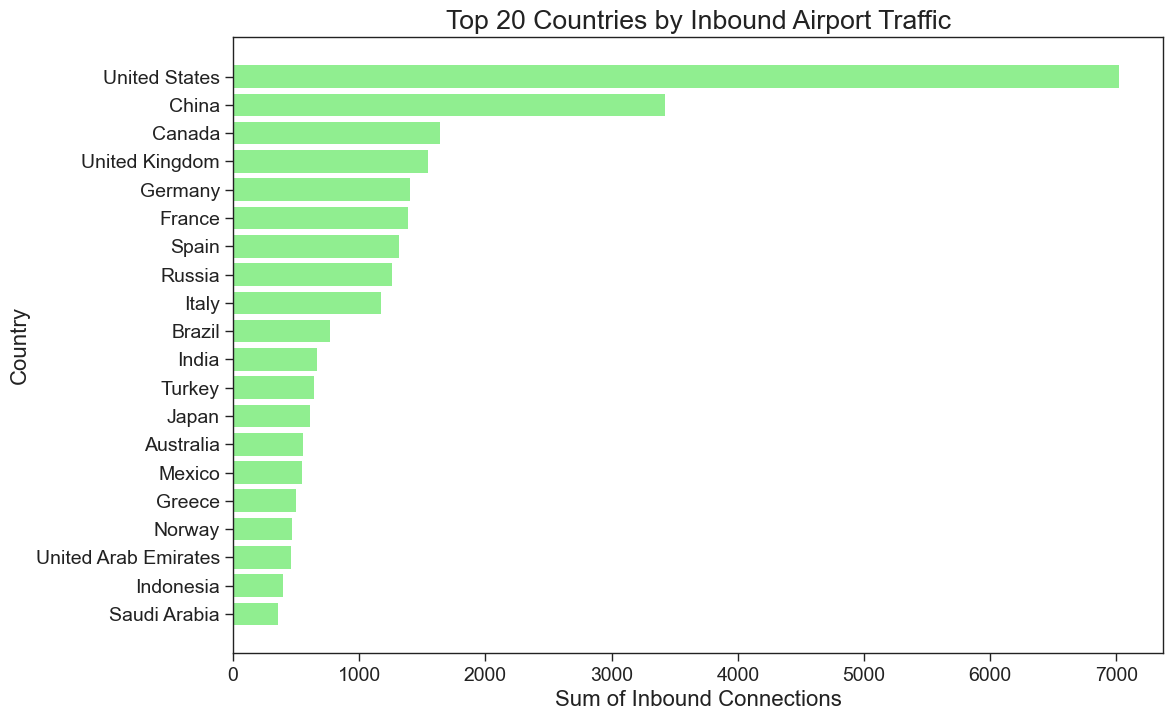

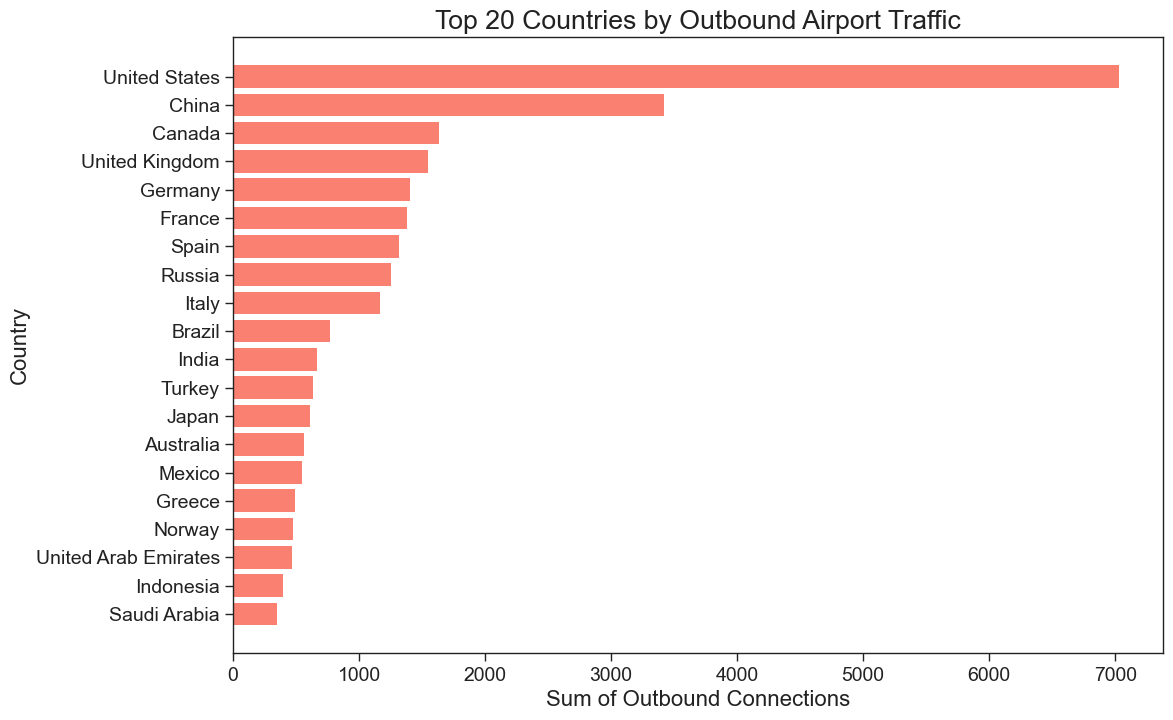

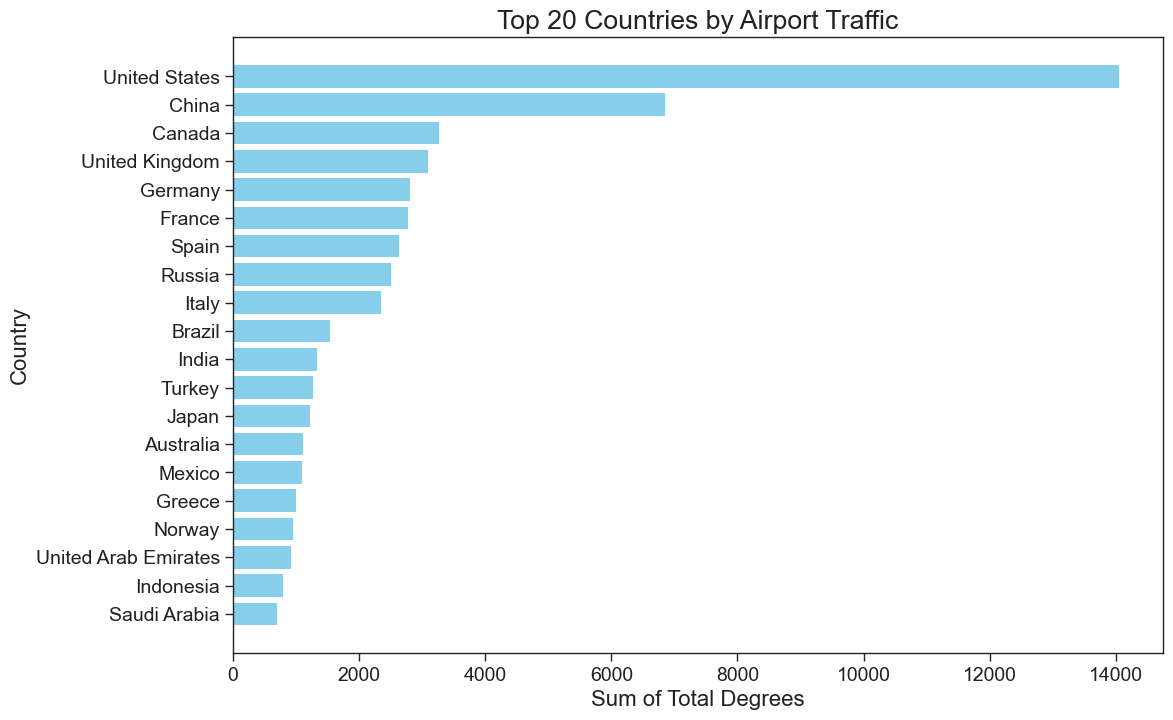

In [ ]:


# Assuming 'country_in_degree_sorted' and 'country_out_degree_sorted' have been calculated as described previously.
N = 20
# For inbound connections
top_countries_in_degree = country_in_degree_sorted.head(N)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_in_degree['Country'], top_countries_in_degree['In_Degree'], color='lightgreen')  
plt.xlabel('Sum of Inbound Connections') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Inbound Airport Traffic') 
plt.gca().invert_yaxis()  # Invert the y-axis to have the country with the highest inbound connectivity at the top
plt.show()

# For outbound connections
top_countries_out_degree = country_out_degree_sorted.head(N)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_out_degree['Country'], top_countries_out_degree['Out_Degree'], color='salmon')  
plt.xlabel('Sum of Outbound Connections') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Outbound Airport Traffic') 
plt.gca().invert_yaxis()  # Invert the y-axis to have the country with the highest outbound connectivity at the top
plt.show()

# Select the top N countries for visualization
top_countries_total_degree = country_total_degree_sorted.head(N)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_total_degree['Country'], top_countries_total_degree['Total_Degree'], color='skyblue')  
plt.xlabel('Sum of Total Degrees') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Airport Traffic') 
plt.gca().invert_yaxis()  # Invert the y-axis to have the country with the highest connectivity at the top
plt.show()


In [ ]:
# Modify G to contain country and continent data for each node (airport)

for node, attributes in G.nodes(data=True):
    lat = attributes['latitude']
    long = attributes['longitude']
    geographic_data = geocode_cache[f'{lat}, {long}']
    G.nodes[node]['country'] = geographic_data['country']
    G.nodes[node]['continent'] = geographic_data['continent']


nx.write_graphml(G, "network.graphml")


In [ ]:
# Count the number of times a node shows up with a specific country, then graph how many airports are in each country
from collections import defaultdict
numberOfAirportsInCountry = defaultdict(int)
numberOfAirportsInContinent = defaultdict(int)

airport_data_cache_country_path = 'airportCountryDataCache.json'
airport_data_cache_continent_path = 'airportContinentDataCache.json'


for nodes, attributes in G.nodes(data=True):
    country = attributes['country']
    continent = attributes['continent']

    numberOfAirportsInCountry[country] += 1
    numberOfAirportsInContinent[continent] += 1


with open(airport_data_cache_country_path, 'w') as airport_data_country_cache:
            json.dump(numberOfAirportsInCountry, airport_data_country_cache, indent=4)


with open(airport_data_cache_continent_path, 'w') as airport_data_continent_cache:
            json.dump(numberOfAirportsInContinent, airport_data_continent_cache, indent=4)


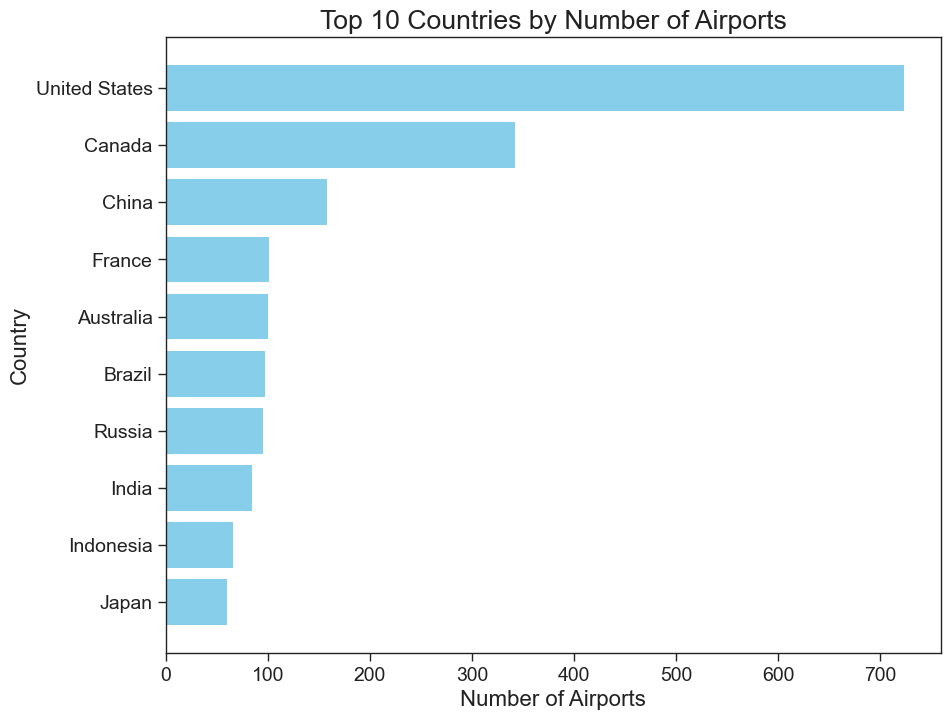

In [ ]:
# plot the data on a graph
country_sorted_airports = sorted(numberOfAirportsInCountry.items(), key=lambda a:a[1], reverse=True) # sort in descending order
continent_sorted_airports = sorted(numberOfAirportsInContinent.items(), key=lambda a:a[1], reverse=True) # sort in descending order

top_10_countries = country_sorted_airports[:10]
top_continents = continent_sorted_airports[:]

countries, airports_counts = zip(*top_10_countries)

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(countries, airports_counts, color='skyblue')
plt.xlabel('Number of Airports')
plt.ylabel('Country')
plt.title('Top 10 Countries by Number of Airports')
plt.gca().invert_yaxis()  # Invert y-axis to have the country with the most airports at the top
plt.show()




In [ ]:
# Are there patterns of dominance by specific airlines in certain regions or route corridor

# Approach
# 0. b/c graph G doesn't contain duplicate edges, use `geo_routes.csv` to extract
# 1. Calculate how many flights were flown by each flight alliance (note source + dest, {alliance: {src_country: # of flights from, src_continent: # of flights from, dest_country:, dest_continent}}) 
# 2. Count the number of times an flight alliance flew to a country or continent


name_changes = {
    'United States of America': 'United States',
    'Dem. Rep. Congo': 'Democratic Republic of the Congo',
    'Central African Rep.': 'Central African Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'Dominican Rep.': 'Dominican Republic',
    'S. Sudan': 'South Sudan',
    'Congo': 'Congo-Brazzaville'
}


df.loc[:, 'Flight Alliance'] = df['Flight Alliance'].fillna('No Alliance')
flights_by_alliance = df['Flight Alliance'].value_counts()

flights_by_alliance_dict = flights_by_alliance.to_dict()

alliance_flight_json_file_path = 'flights_by_alliance.json'  
alliance_flight_geo_file_path = 'alliance_flight_distribution.json'

with open(alliance_flight_json_file_path, 'w') as json_file:
    json.dump(flights_by_alliance_dict, json_file, indent=4)

df_flights = df


# Helper function to get country and continent from latitude and longitude
def get_geo_info(lat, lon):
    coords = f"{lat}, {lon}"
    return geocode_cache[coords]

# Apply the helper function to source and destination lat/lon to get country and continent
df_flights['src_geo'] = df_flights.apply(lambda x: get_geo_info(x['lat_src'], x['lng_src']), axis=1)
df_flights['dest_geo'] = df_flights.apply(lambda x: get_geo_info(x['lat_dest'], x['lng_dest']), axis=1)

# Extract country and continent into separate columns
df_flights['src_country'] = df_flights['src_geo'].apply(lambda x: x['country'])
df_flights['src_continent'] = df_flights['src_geo'].apply(lambda x: x['continent'])
df_flights['dest_country'] = df_flights['dest_geo'].apply(lambda x: x['country'])
df_flights['dest_continent'] = df_flights['dest_geo'].apply(lambda x: x['continent'])

# Group by flight alliance and calculate counts
flights_alliance_summary = df_flights.groupby('Flight Alliance').apply(
    lambda x: {
        'src_country': x['src_country'].value_counts().to_dict(),
        'src_continent': x['src_continent'].value_counts().to_dict(),
        'dest_country': x['dest_country'].value_counts().to_dict(),
        'dest_continent': x['dest_continent'].value_counts().to_dict()
    }
).to_dict()

with open(alliance_flight_geo_file_path, 'w') as json_file2:
    json.dump(flights_alliance_summary, json_file2, indent=4)

flights_alliance_summary




/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_3135/466550461.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flights_alliance_summary = df_flights.groupby('Flight Alliance').apply(


{'No Value': {'src_country': {'United States': 5379,
   'China': 4510,
   'United Kingdom': 1952,
   'Spain': 1648,
   'Canada': 1643,
   'Germany': 1480,
   'India': 1455,
   'France': 1379,
   'Italy': 1208,
   'Russia': 1172,
   'Brazil': 938,
   'Indonesia': 777,
   'United Arab Emirates': 690,
   'Australia': 651,
   'Japan': 600,
   'Greece': 563,
   'Mexico': 544,
   'Turkey': 536,
   'Malaysia': 512,
   'Saudi Arabia': 482,
   'Norway': 466,
   'Iran': 414,
   'Thailand': 383,
   'Philippines': 354,
   'Portugal': 331,
   'Netherlands': 277,
   'Pakistan': 267,
   'Sweden': 261,
   'Ireland': 250,
   'Poland': 247,
   'Colombia': 244,
   'Singapore': 241,
   'Taiwan': 232,
   'Morocco': 220,
   'Belgium': 212,
   'Algeria': 198,
   'Switzerland': 191,
   'Argentina': 190,
   'Tunisia': 180,
   'Kazakhstan': 178,
   'Austria': 177,
   'Egypt': 175,
   'South Korea': 160,
   'Ukraine': 159,
   'Venezuela': 152,
   'Qatar': 147,
   'Denmark': 139,
   'Papua New Guinea': 135,
   'S

In [16]:
import geopandas as gpd
from matplotlib.colors import LogNorm
# Load world shape map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))




# Merge the geopandas DataFrame with your airports data

geo_country_names = set(world['name'])
json_country_names = set(numberOfAirportsInCountry.keys())
print(geo_country_names)
# Find names in JSON data that don't have an exact match in the GeoDataFrame
unmatched_names = json_country_names - geo_country_names

print(f"Unmatched Country Names: {unmatched_names}")
numAirportsModified = numberOfAirportsInCountry.copy()
# manually fix some naming inconsistencies

numAirportsModified['United States of America'] = numAirportsModified['United States']
numAirportsModified['Dem. Rep. Congo'] = numAirportsModified['Democratic Republic of the Congo']
numAirportsModified['Central African Rep.'] = numAirportsModified['Central African Republic']
numAirportsModified['Eq. Guinea'] = numAirportsModified['Equatorial Guinea']
numAirportsModified['Dominican Rep.'] = numAirportsModified['Dominican Republic']
numAirportsModified['S. Sudan'] = numAirportsModified['South Sudan']
numAirportsModified['Congo'] = numAirportsModified['Congo-Brazzaville']

world['number_of_airports'] = world['name'].map(numAirportsModified).fillna(0)




vmin, vmax = world['number_of_airports'].replace(0, pd.NA).dropna().min(), world['number_of_airports'].max()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with the number of airports per country
world.plot(column='number_of_airports', ax=ax, legend=True,
           norm=LogNorm(vmin=vmin, vmax=vmax),
           cmap='viridis',
           legend_kwds={'label': "Number of Airports by Country (Log Scale)",
                        'shrink': 0.5,
                        'orientation': "horizontal"},)

# Show the plot
plt.show()


/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_81934/4069098431.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


NameError: name 'numberOfAirportsInCountry' is not defined

In [ ]:
# Modify alliance_flight_distribution to have geopy names
# Fixes some data inconsistencies with some countries not having values.

with open(alliance_flight_geo_file_path, 'r') as file:
    flights_alliance_summary = json.load(file)

# Define a dictionary for the name changes
name_changes = {
    'United States':'United States of America' ,
     'Democratic Republic of the Congo':'Dem. Rep. Congo',
    'Central African Republic': 'Central African Rep.',
    'Equatorial Guinea': 'Eq. Guinea', 
    'Dominican Republic': 'Dominican Rep.',
    'South Sudan' :'S. Sudan',
    'Congo-Brazzaville': 'Congo',
    # Add any additional mappings as needed
}

# apply the name changes to the summary data
for alliance, data in flights_alliance_summary.items():
    for src_dest in ['src_country', 'dest_country']:
        for old_name, new_name in name_changes.items():
            if old_name in data[src_dest]:
                data[src_dest][new_name] = data[src_dest].get(new_name, 0) + data[src_dest][old_name]


# find all unique countries mentioned across all alliances
# ensure each country exists in each alliance's src_country and dest_country, set to 0 if not present
unique_countries = set()
for alliance_data in flights_alliance_summary.values():
    unique_countries.update(alliance_data['src_country'].keys())
    unique_countries.update(alliance_data['dest_country'].keys())


for alliance, data in flights_alliance_summary.items():
    for country in unique_countries:
        data['src_country'].setdefault(country, 0)
        data['dest_country'].setdefault(country, 0)


with open(alliance_flight_geo_file_path, 'w') as file:
    json.dump(flights_alliance_summary, file, indent=4)


/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_81934/1264880741.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


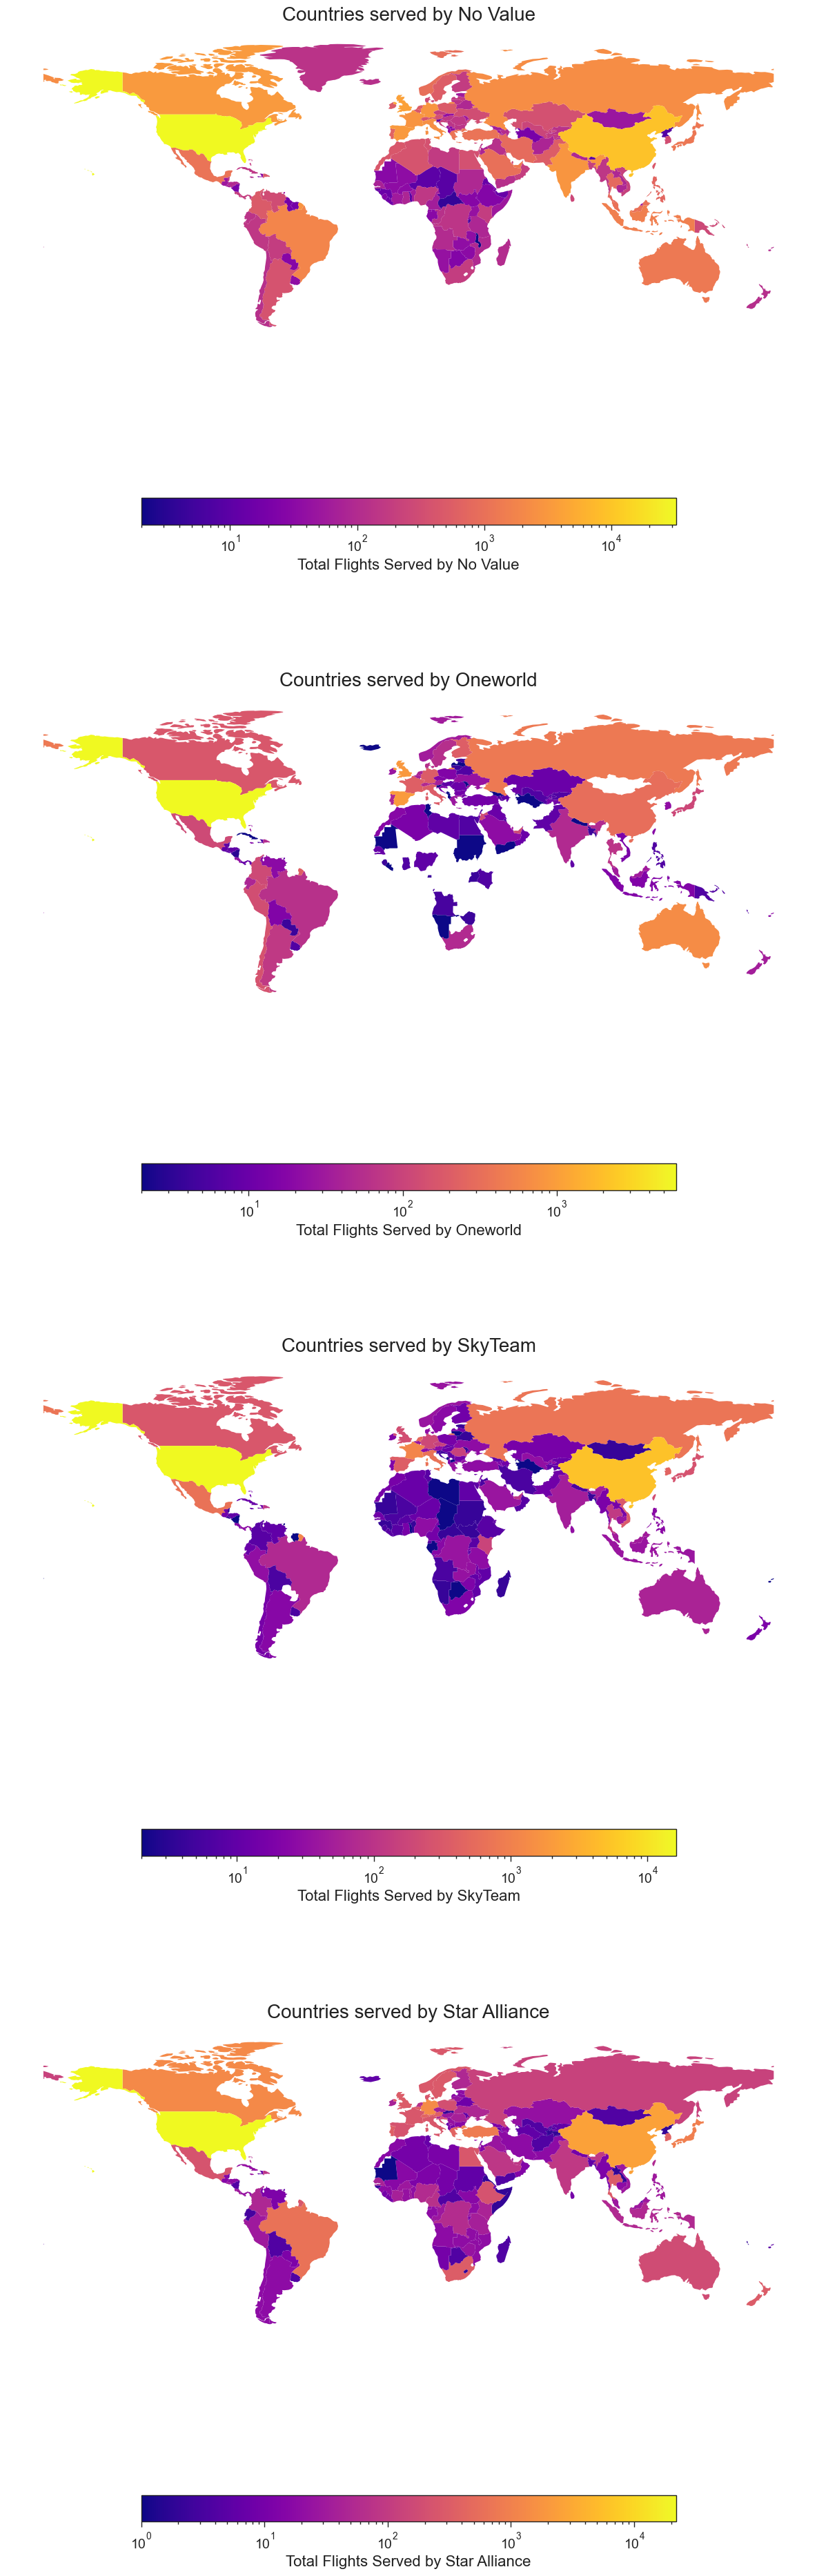

In [18]:
# "Countries served" = # of times alliance has flown from country + # of times alliance has flown to country
import json

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


alliance_flight_geo_file_path = 'alliance_flight_distribution.json'

with open(alliance_flight_geo_file_path, 'r') as file:
    flights_alliance_summary = json.load(file)


# prepare figures, one for each alliance

alliances = flights_alliance_summary.keys()
n_alliances = len(flights_alliance_summary)



# We will plot each alliance on a separate subplot
fig, axes = plt.subplots(n_alliances, 1, figsize=(20, n_alliances * 12))



def calculate_total_flights(alliance_data, column_prefix):
    total_flights = {}
    for country, num_flights in alliance_data[column_prefix].items():
        total_flights[country] = num_flights
    return total_flights

# Plot a choropleth map for each alliance
for idx, (alliance, ax) in enumerate(zip(alliances, axes.flatten())):

    total_flights_from = calculate_total_flights(flights_alliance_summary[alliance], 'src_country')
    total_flights_to = calculate_total_flights(flights_alliance_summary[alliance], 'dest_country')
    total_flights = {country: total_flights_from.get(country, 0) + total_flights_to.get(country, 0)
                     for country in set(total_flights_from) | set(total_flights_to)}
    world['total_flights'] = world['name'].apply(lambda x: total_flights.get(x, 0))
    
    # set up the normalization for the color scale
    vmin = world['total_flights'].replace(0, pd.NA).dropna().min()
    vmax = world['total_flights'].max()
    
    # plot the world map for each alliance
    world.plot(column='total_flights', ax=ax, legend=True,
               norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',
               legend_kwds={'label': f"Total Flights Served by {alliance}",
                            'shrink': 0.5,
                            'orientation': "horizontal"})
    
    ax.set_title(f"Countries served by {alliance}", fontdict={'fontsize': 20})
    

    ax.set_axis_off()

plt.show()
fig.savefig('alliance_map.png')